In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import summa
import pandas as pd
import urllib.request
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv("news_summary_more.csv", encoding="iso-8859-1")

In [3]:
data.sample(10)

,headlines,text
47041,Three UK cities partner to attract more touris...,Three of UK's largest cities have partnered to...
80615,Kermit the Frog voice actor claims he was fire...,"The voice actor of Kermit the Frog, Steve Whit..."
74985,Trump calls Kim Jong-Un's decision to not atta...,North Korea made a wise and well reasoned deci...
78526,Axis Bank buys FreeCharge from Snapdeal for $6...,Snapdeal-owned recharge app FreeCharge was on ...
45347,"Nirav Modi bribed PNB official with gold, jewe...",The CBI on Saturday said billionaire jeweller ...
72677,Airbnb slammed for 'floating homes' ad during ...,Homestay startup Airbnb has been slammed for i...
39909,7 arrested for spreading fake news on Nipah vi...,Police have arrested seven people in Kerala's ...
42312,"Syria, Russia agree on ceasefire with rebels i...",The Syrian Army and Russia have agreed to a ce...
64913,Mumbai civic body opens online portal for busi...,The Brihanmumbai Municipal Corporation has int...
94260,Kim Sharma bankrupt after separation from husb...,"As per reports, actress Kim Sharma, who debute..."


# 데이터 전처리하기(추상적 요약)

In [4]:
# 중복 샘플과 NULL 값이 존재하는 샘플 제거
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print("summary 열에서 중복을 배제한 유일한 샘플의 수 :", data["headlines"].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# text 열에서 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 98360


In [6]:
# 데이터프레임에 Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
print("정규화 사전의 수 :",len(contractions))

정규화 사전의 수 : 120


In [8]:
# 불용어 확인
print("불용어 개수 :", len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text
    sentence = re.sub(r"\([^]]*\)", '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}','mm', sentence)
    
    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거(headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1 )
    return tokens

In [10]:
# 데이터 전처리 함수 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print('text: ', preprocess_sentence(temp_text))
print('summary:', preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [11]:
# text 열 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
print("text 전처리 후 결과:", clean_text[:5])

text 전처리 후 결과: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure

In [12]:
# headlines 전처리
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))
    
print("headlines 전처리 후 결과:", clean_summary[:5])

headlines 전처리 후 결과: ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


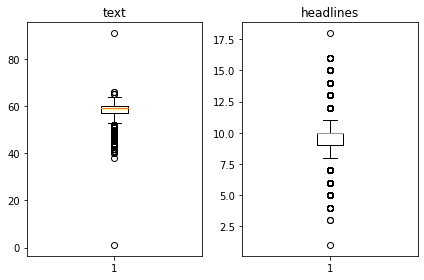

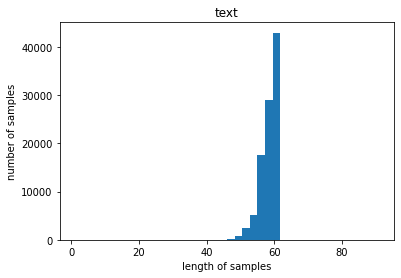

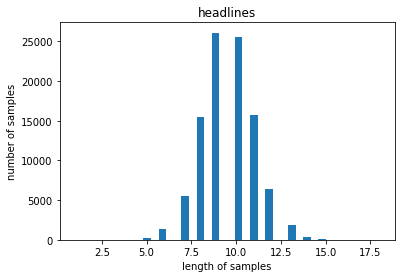

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print("텍스트의 최소 길이 : {}".format(np.min(text_len)))
print("텍스트의 최대 길이 : {}".format(np.max(text_len)))
print("텍스트의 평균 길이 : {}".format(np.mean(text_len)))
print("요약의 최소 길이 : {}".format(np.min(headlines_len)))
print("요약의 최대 길이 : {}".format(np.max(headlines_len)))
print("요약의 평균 길이 : {}".format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 50
headlines_max_len = 8

In [16]:
# 샘플 길이 수 이하 비율
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.011752745018300122
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2279686864579097


In [19]:
data = data[data['text'].apply(lambda x: len(x.split())<= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print("전체 샘플수: ", (len(data)))

전체 샘플수:  463


In [20]:
# 시작 토근과 종료 토큰 추가하기
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken' + x)
data['decoder_target'] = data['headlines'].apply(lambda x :x + 'eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
52,headlines,text,sostokenheadlines,headlineseostoken
708,Malayalam actor Mohanlal conferred with Padma ...,Malayalam film actor Mohanlal will be awarded ...,sostokenMalayalam actor Mohanlal conferred wit...,Malayalam actor Mohanlal conferred with Padma ...
1210,Will organise Bhojpuri Mahotsav next year: Mau...,Speaking at the Pravasi Bharatiya Divas concla...,sostokenWill organise Bhojpuri Mahotsav next y...,Will organise Bhojpuri Mahotsav next year: Mau...
1437,Bacteria-inspired microbots that adapt to surr...,Switzerland-based researchers have made bacter...,sostokenBacteria-inspired microbots that adapt...,Bacteria-inspired microbots that adapt to surr...
2137,"Inox to add 850 screens, plans all-kids theatres",The country's second-largest multiplex chain I...,"sostokenInox to add 850 screens, plans all-kid...","Inox to add 850 screens, plans all-kids theatr..."


In [21]:
# 인코더 입력, 디코더 입력과 레이블을 Nupy 타입으로 저장
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [23]:
# shuffle 설정
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[345 320 260 279 236 379 315 362 221  56 370 274 252 450 115 125 386  22
 333 180 201 249 165 163  64 455 231  19 237 208 430 209 100   3  43 446
  39 373 339 350 146 132  94  66 205  35 447 372 367 357 325 459  98 410
 383 262 452   4 103 147 427 310 449 365  89 461 116  14 324 443 140  91
 425 142 269  68 281 378  49 418  61 152   2 349 380   6 222 397  59 307
 135 331 150  82 190 275 256 191 177 157 458 148 105 186 460 283 136  60
 316 348 382  23 421 188 327  88 351 174 270 294 423 356  24 112 156 313
 280 154 122 360 144 391  33 108 296 228 398 232 248 139 257 439 133 218
 276 426  65 264 255 253  72 342 210 207 244  55 311 435  40 172 416 407
 317  25 381 178  41 306 415 395 403 278 193 273  97 336 120  96 456 338
 182 341  36 304 169 302 254 301 424 291 173 419 387 322 406 118 405 153
 162 314 225 265 369 251 200 267  30  37  17 259 429 131 384 266 448  67
 166  28 223 346 329  48 352  77 179  62 431 323  63 214  20 107 121 374
 457 164 220 437 440 247 366 390 337  38 358 328 17

In [24]:
# 데이터의 샘플 순서 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 테스트 비율 설정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 92


In [26]:
#훈련 데이터와 테스트 데이터 분류
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print("훈련 데이터의 개수 :", len(encoder_input_train))
print("훈련 레이블의 개수 :", len(decoder_input_train))
print("테스트 데이터의 개수 :", len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 371
훈련 레이블의 개수 : 371
테스트 데이터의 개수 : 92
테스트 레이블의 개수 : 92


In [27]:
# 토크나이저 정의
src_tokenizer = Tokenizer()

#입력된 데이터로부터 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train)

In [38]:
# 등장 빈도수가 낮은 단어 수 제거
threshold = 5
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vlcabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

단어 집합(vlcabulary)의 크기 : 5489
등장 빈도가 4번 이하인 희귀 단어의 수: 4884
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 605
단어 집합에서 희귀 단어의 비율: 88.97795591182364
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 38.7276427117918


In [31]:
# 단어 집합 제한
src_vocab = 600
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [32]:
#텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_train[:3])

[[50, 2, 375, 8, 16, 106, 3, 4, 376, 264, 22, 1, 9, 11, 78, 6, 4, 10, 14, 1, 61, 154, 8, 265], [2, 35, 56, 142, 32, 266, 116, 5, 2, 22, 1, 1, 5, 1, 92, 126, 11, 116, 4, 1, 319, 30, 3, 473, 142, 18], [267, 62, 97, 196, 155, 17, 23, 474, 78, 39, 98, 1, 63, 18, 33, 377, 3, 15, 475, 50, 5, 2, 222, 3, 320, 19, 30, 107, 5, 23, 321, 12, 174]]


In [39]:
# headlines 데이터의 단어 집합과 빈도수 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 3
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1863
등장 빈도가 2번 이하인 희귀 단어의 수: 1710
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 153
단어 집합에서 희귀 단어의 비율: 91.78743961352657
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 66.49251132009752


In [40]:
# 테스트 시퀀스 단어 집합 제한
tar_vocab = 200
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [41]:
#텍스트 데이터 정수로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input', decoder_input_train[:5])
print('target')
print('decoder', decoder_target_train[:5])

input
input [[56, 43, 34, 1, 161], [162, 90, 28, 163], [], [4, 57, 91], [4, 92, 6]]
target
decoder [[56, 43, 34, 1, 161], [90, 28, 163], [], [4, 57, 91], [4, 92, 6]]


In [43]:
# 요약문 길이가 1인 경우 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence)==1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence)==1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 34
훈련 데이터의 개수 : 315
훈련 레이블의 개수 : 315
테스트 데이터의 개수 : 58
테스트 레이블의 개수 : 58


In [44]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 어텐션 모델 구현하기

In [68]:
from tensorflow.keras.layers import LSTM, Input, Embedding, Dense, Concatenate

In [60]:
# 인코더 설계
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

#인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#인코더의 LSTM
encoder_lstm = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [61]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

In [64]:
#디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [70]:
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model

attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      76800       input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 128)    25600       input_5[0][0]                    
______________________________________________________________________________________________

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train],
                   y=decoder_target_train,
                   validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                   batch_size=256, callbacks=[es], epochs=10)

ValueError: Data cardinality is ambiguous:
  x sizes: 315, 315
  y sizes: 371
Make sure all arrays contain the same number of samples.